# Deep Dream

Deep Dream is an algorithm able to generate artistic figures starting from an input image. To make this magic happen, Deep Dream makes use of a pretrained CNN (Convolutional Neural Network). 

This notebook was realised based on the following article: https://hackernoon.com/dl06-deepdream-with-code-5f735052e21f

## Preprocessing

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops

In [0]:
def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    return image

normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225])  + torch.Tensor([0.485, 0.456, 0.406])

## Loading Pretrained model

In [11]:
# Loading pretrained model
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()
print(vgg)
modulelist = list(vgg.features.modules())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
# Take an input image, make a forward pass till a particular layer, and then updates the input image by gradient ascent.
def dd_helper(image, layer, iterations, lr):        
    
    input = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
    vgg.zero_grad()
    for i in range(iterations):
        out = input
        for j in range(layer):
            out = modulelist[j+1](out)
        loss = out.norm()
        loss.backward()
        input.data = input.data + lr * input.grad.data
    
    input = input.data.squeeze()
    input.transpose_(0,1)
    input.transpose_(1,2)
    input = np.clip(deprocess(input.cpu()), 0, 1)
    im = Image.fromarray(np.uint8(input*255))
    return im

In [0]:
# Repeatedly downscales the image, then call dd_helper (recursively). 
# Succesively upscale the result, and merge it to the image at one level higher on the recursive tree. 
# The final image is the same size as the input image.
def deep_dream_vgg(image, layer, iterations, lr, octave_scale, num_octaves):
    
    # Octave = The input image is repeatedly downscaled, 
    # and gradient ascent is applied to all the images, 
    # finally the result is merged into a single output image.
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale<1):
            size = image1.size
        else:
            size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))
            
        image1 = image1.resize(size,Image.ANTIALIAS)
        image1 = deep_dream_vgg(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size,Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

## Deep Dream!

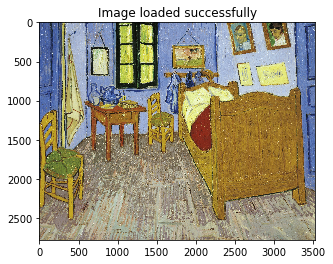

In [38]:
# Shallow layers learn basic shapes, lines, edges (succsive layers learn patterns) 
# Deeper layers can learn much more complex features like eyes, face, etc.
sky = load_image('/content/gettyimages-153049519.jpg')

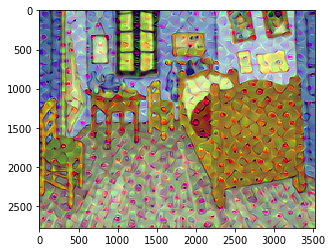

In [40]:
sky_28 = deep_dream_vgg(sky, 10, 4, 0.3, 3, 10)